In [3]:
from datasets import load_dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = load_dataset("GroNLP/ik-nlp-22_transqe")["train"].to_pandas()
df

,premise_en,premise_nl,hypothesis_en,hypothesis_nl,label,explanation_1_en,explanation_1_nl,explanation_2_en,explanation_2_nl,explanation_3_en,...,da_premise,mqm_premise,da_hypothesis,mqm_hypothesis,da_explanation_1,mqm_explanation_1,da_explanation_2,mqm_explanation_2,da_explanation_3,mqm_explanation_3
0,A person on a horse jumps over a broken down a...,Een persoon op een paard springt over een kapo...,A person is training his horse for a competition.,Iemand traint zijn paard voor een wedstrijd.,1,the person is not necessarily training his horse,de persoon traint niet noodzakelijkerwijs zijn...,,,,...,0.3882,0.1117,0.7113,0.1305,0.5262,0.1318,,,,
1,A person on a horse jumps over a broken down a...,Een persoon op een paard springt over een kapo...,"A person is at a diner, ordering an omelette.","Een persoon is in een restaurant, bestelt een ...",2,One cannot be on a jumping horse cannot be a d...,Men kan niet op een springpaard zitten kan gee...,,,,...,0.388,0.1117,0.1745,0.133,0.0027,0.0606,,,,
2,A person on a horse jumps over a broken down a...,Een persoon op een paard springt over een kapo...,"A person is outdoors, on a horse.","Een persoon is buiten, op een paard.",0,a broken down airplane is outdoors,een kapot vliegtuig is buiten,,,,...,0.3883,0.1117,0.0003,0.1126,0.5602,0.1126,,,,
3,Children smiling and waving at camera,Kinderen lachen en zwaaien naar de camera,They are smiling at their parents,Ze lachen naar hun ouders,1,Just because they are smiling and waving at a ...,Alleen omdat ze lachen en zwaaien naar een cam...,,,,...,0.641,0.1189,0.421,0.1209,0.3506,0.1161,,,,
4,Children smiling and waving at camera,Kinderen lachen en zwaaien naar de camera,There are children present,Er zijn kinderen aanwezig,0,The children must be present to see them smili...,De kinderen moeten aanwezig zijn om ze te zien...,,,,...,0.641,0.1189,0.981,0.143,0.6185,0.1171,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549362,Four dirty and barefooted children.,Vier vieze en blote voeten kinderen.,four kids won awards for 'cleanest feet',vier kinderen wonnen prijzen voor'schoonste vo...,2,in a both sentence dirty and cleanest are not ...,in een beide zin vuil en schoonste zijn niet h...,,,,...,0.0436,0.101,0.3029,0.112,0.0,0.078,,,,
549363,Four dirty and barefooted children.,Vier vieze en blote voeten kinderen.,"four homeless children had their shoes stolen,...",Vier dakloze kinderen hebben hun schoenen gest...,1,the children are not necessarily homeless,de kinderen zijn niet noodzakelijk dakloos,,,,...,0.046,0.1009,0.3846,0.1052,0.7115,0.1369,,,,
549364,A man is surfing in a bodysuit in beautiful bl...,Een man surft in een lijkpak in prachtig blauw...,A man in a bodysuit is competing in a surfing ...,Een man in een bodysuit doet mee aan een surfw...,1,the man is not necessarily competing,de man is niet per se competitief,,,,...,0.5112,0.1175,0.7024,0.1386,0.5658,0.1244,,,,
549365,A man is surfing in a bodysuit in beautiful bl...,Een man surft in een lijkpak in prachtig blauw...,A man in a business suit is heading to a board...,Een man in een zakenpak gaat naar een bestuurs...,2,That is either a business suit or bodysuit.,Dat is een zakenpak of een bodysuit.,,,,...,0.5113,0.1174,0.3934,0.1289,0.1277,0.1115,,,,


In [4]:
df["da_hypothesis"] = df["da_hypothesis"].astype("float")
df["da_premise"] = df["da_premise"].astype("float")
df["mqm_hypothesis"] = df["mqm_hypothesis"].astype("float")
df["mqm_premise"] = df["mqm_premise"].astype("float")

<Axes: xlabel='da_hypothesis', ylabel='da_premise'>

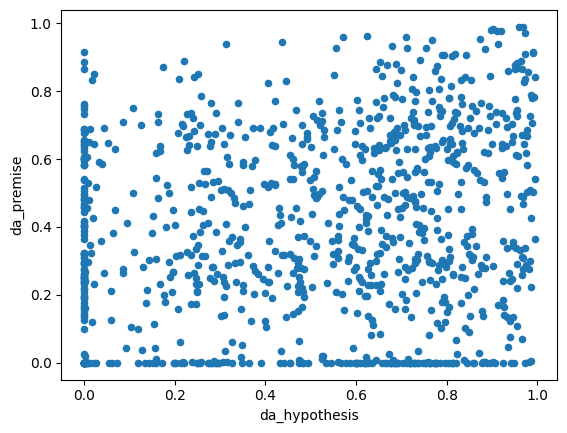

In [5]:
df.sample(1000).plot(kind="scatter", x = "da_hypothesis", y = "da_premise")

<Axes: xlabel='mqm_hypothesis', ylabel='mqm_premise'>

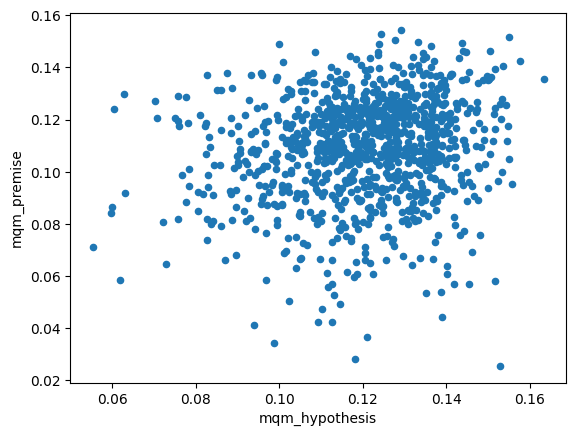

In [6]:
df.sample(1000).plot(kind="scatter", x = "mqm_hypothesis", y = "mqm_premise")

<Axes: xlabel='da_hypothesis', ylabel='mqm_hypothesis'>

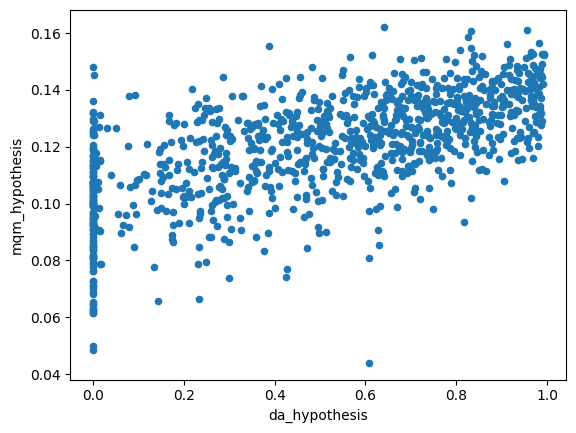

In [7]:
df.sample(1000).plot(kind="scatter", x = "da_hypothesis", y = "mqm_hypothesis")

<Axes: xlabel='da_premise', ylabel='mqm_premise'>

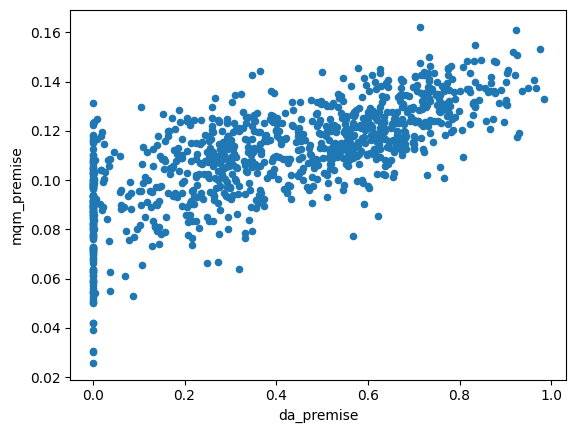

In [8]:
df.sample(1000).plot(kind="scatter", x = "da_premise", y = "mqm_premise")

In [4]:
def value_from_percentage(percentage: float, cols: list[str], df: pd.DataFrame):
    """Given a percentage, approximates for what da or mqm thershold, you keep
    that percentage of data, given all da/mqm filter values are the same.
    """
    
    min = 0.0
    max = 1.0
    total_len = len(df)

    for _ in range(100):
        new_try = (min + max) / 2.0
        new_len = (df[cols] > new_try).all(axis=1).sum()
        new_perc = new_len / total_len
        if new_perc > percentage:
            min = new_try
        else:
            max = new_try
    
    print(f"I found value {new_try}, which keeps {new_perc:.5f} of the original length ({new_len}/{total_len})")

value_from_percentage(0.1, ["mqm_hypothesis", "mqm_premise"], df)

I found value 0.127, which keeps 0.09942 of the original length (54616/549367)


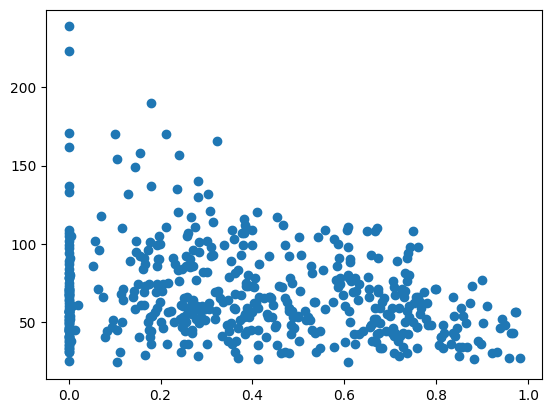

In [26]:
tmp_df = df.sample(500)
da_p = tmp_df["da_premise"].to_list()
len_p = [len(s) for s in tmp_df["premise_nl"].to_list()]
plt.scatter(da_p, len_p)
plt.show()

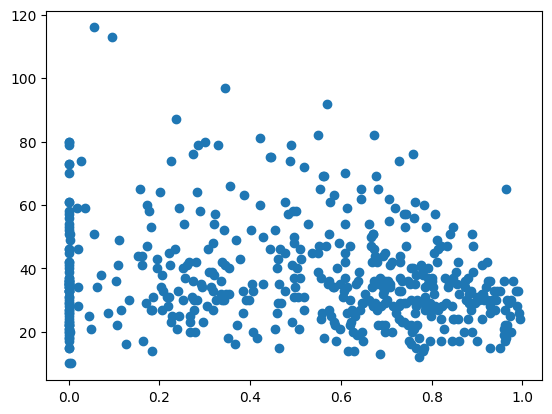

In [32]:
tmp_df = df.sample(500)
da_h = tmp_df["da_hypothesis"].to_list()
len_h = [len(s) for s in tmp_df["hypothesis_nl"].to_list()]
plt.scatter(da_h, len_h)
plt.show()

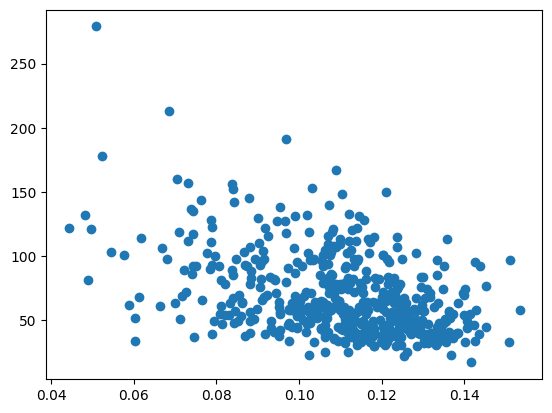

In [27]:
tmp_df = df.sample(500)
mqm_p = tmp_df["mqm_premise"].to_list()
len_p = [len(s) for s in tmp_df["premise_nl"].to_list()]
plt.scatter(mqm_p, len_p)
plt.show()

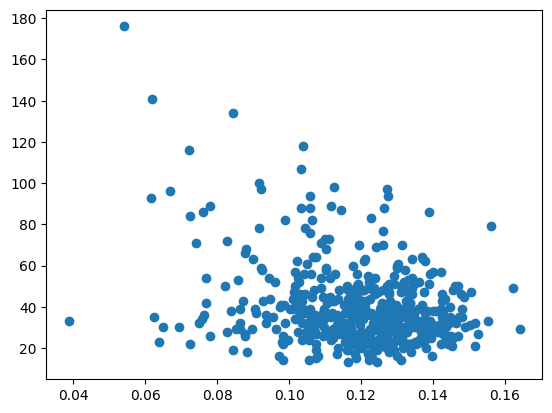

In [34]:
tmp_df = df.sample(500)
mqm_h = tmp_df["mqm_hypothesis"].to_list()
len_h = [len(s) for s in tmp_df["hypothesis_nl"].to_list()]
plt.scatter(mqm_h, len_h)
plt.show()

In [55]:
# Now doing the same as before, but such that it can do da and mqm at the same time
# Will normalize both score for this and then convert back
def norm_value_from_percentage(percentage: float, df: pd.DataFrame):
    da_cols = ["da_premise", "da_hypothesis"]
    mqm_cols = ["mqm_premise", "mqm_hypothesis"]
    
    all_da = df[da_cols[0]].to_list() + df[da_cols[1]].to_list()
    all_mqm = df[mqm_cols[0]].to_list() + df[mqm_cols[1]].to_list()
    da_mean, mqm_mean = np.mean(all_da), np.mean(all_mqm)
    da_std, mqm_std = np.std(all_da), np.std(all_mqm)

    min = -3.0
    max = 3.0
    total_len = len(df)

    for _ in range(100):
        new_try = (min + max) / 2.0
        da = da_mean + new_try * da_std
        mqm = mqm_mean + new_try * mqm_std
        
        da_th = (df[da_cols] > da).all(axis=1)
        mqm_th = (df[mqm_cols] > mqm).all(axis=1)
        new_len = (da_th & mqm_th).sum()
        new_perc = new_len / total_len

        if new_perc > percentage:
            min = new_try
        else:
            max = new_try
        
    print(f"I found normalized value {new_try}, which keeps {new_perc:.5f} of the original length ({new_len}/{total_len})")
    print(f"DA = {da} ; MQM = {mqm}")
    

norm_value_from_percentage(0.1, df)

I found normalized value 0.3598335398428264, which keeps 0.09957 of the original length (54700/549367)
DA = 0.5550792862302256 ; MQM = 0.1219


In [44]:
da_cols = ["da_premise", "da_hypothesis"]
mqm_cols = ["mqm_premise", "mqm_hypothesis"]

da_th = df[da_cols] > 0.44642979802208715
mqm_th = df[mqm_cols] > 0.11473727180555075

(da_th.all(axis=1) & mqm_th.all(axis=1)).sum()

107566

In [ ]:
# def value_from_percentage(percentage: float, cols: list[str], df: pd.DataFrame):
#     """Given a percentage, approximates for what da or mqm thershold, you keep
#     that percentage of data, given all da/mqm filter values are the same.
#     """
    
#     min = 0.0
#     max = 1.0
#     total_len = len(df)

#     for _ in range(100):
#         new_try = (min + max) / 2.0
#         new_len = (df[cols] > new_try).all(axis=1).sum()
#         new_perc = new_len / total_len
#         if new_perc > percentage:
#             min = new_try
#         else:
#             max = new_try
    
#     print(f"I found value {new_try}, which keeps {new_perc:.5f} of the original length ({new_len}/{total_len})")

# value_from_percentage(0.1, ["mqm_hypothesis", "mqm_premise"], df)